# CIFAR-10 Image Classification with Experiment Tracking
Track experiments for model improvements on CIFAR-10 dataset

In [31]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [32]:
# Setup GPU device
import pandas as pd
from datetime import datetime
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')

# Initialize experiment tracker
experiment_results = []

Using device: cuda
GPU: NVIDIA GeForce RTX 5090
Memory: 31.84 GB


In [33]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 128

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

frog  dog   truck cat   truck car   truck dog   truck bird  car   dog   frog  bird  truck truck horse bird  cat   frog  plane horse ship  deer  plane horse cat   plane car   dog   car   horse bird  dog   ship  ship  horse plane frog  ship  truck truck bird  ship  ship  plane car   bird  cat   dog   deer  cat   deer  truck deer  frog  cat   truck deer  cat   car   plane ship  horse cat   plane cat   plane dog   deer  car   deer  horse frog  bird  frog  deer  horse dog   cat   bird  ship  car   truck cat   deer  ship  ship  plane frog  horse deer  frog  bird  bird  cat   truck plane horse plane bird  cat   bird  frog  bird  car   frog  bird  cat   bird  frog  cat   dog   truck deer  cat   truck frog  frog  truck bird  dog   ship  frog  horse bird  deer  truck


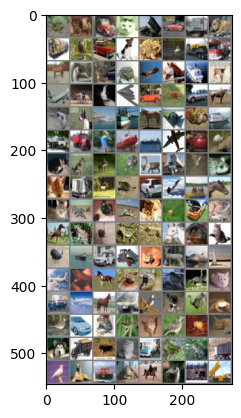

In [34]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [35]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net().to(device)  # Move model to GPU
print(f'Model moved to {device}')

Model moved to cuda


In [36]:
# Hyperparameters for this experiment
learning_rate = 0.001
momentum = 0.9
num_epochs = 100
weight_decay = 0

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Track experiment configuration
current_experiment = {
    'experiment_id': len(experiment_results) + 1,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_architecture': 'Basic CNN (2 conv, 3 fc)',
    'optimizer': 'SGD',
    'learning_rate': learning_rate,
    'momentum': momentum,
    'weight_decay': weight_decay,
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'device': str(device)
}

In [ ]:
# Training loop with timing
print(f"Starting training on {device}...")
training_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0
    
    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch + 1} completed in {epoch_time:.2f}s")

training_time = time.time() - training_start_time
print(f'Finished training in {training_time:.2f}s ({training_time/60:.2f} minutes)')

# Store training time in experiment
current_experiment['training_time_seconds'] = training_time

Starting training on cuda...
Epoch 1 completed in 3.38s
Epoch 2 completed in 3.61s
Epoch 3 completed in 3.35s
Epoch 4 completed in 3.39s
Epoch 5 completed in 3.33s
Epoch 6 completed in 3.33s
Epoch 7 completed in 3.49s
Epoch 8 completed in 3.35s
Epoch 9 completed in 2.33s
Epoch 10 completed in 3.34s
Epoch 11 completed in 3.28s
Epoch 12 completed in 3.33s
Epoch 13 completed in 3.48s
Epoch 14 completed in 3.44s
Epoch 15 completed in 3.35s
Epoch 16 completed in 3.37s
Epoch 17 completed in 3.40s
Epoch 18 completed in 3.37s
Epoch 19 completed in 2.29s


In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Groundtruth:  cat   ship  ship  plane


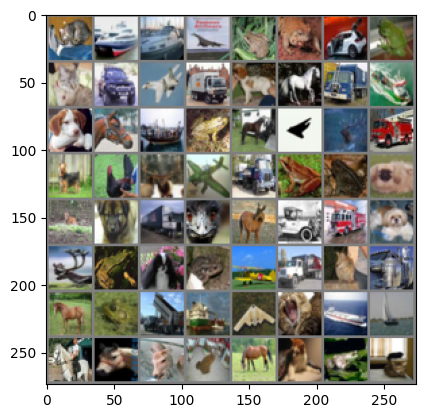

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('Groundtruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net = Net().to(device)  # Move to GPU
net.load_state_dict(torch.load(PATH, weights_only=True))
net.eval()  # Set to evaluation mode

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# Move images to GPU for inference
images = images.to(device)
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   car   ship  plane


In [ ]:
# Evaluate on full test set
print("Evaluating model on test set...")
eval_start_time = time.time()

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

eval_time = time.time() - eval_start_time
test_accuracy = 100 * correct / total

print(f'Accuracy of the network on the 10000 test images: {test_accuracy:.2f}%')
print(f'Evaluation completed in {eval_time:.2f}s')

# Store results in experiment tracker
current_experiment['test_accuracy'] = test_accuracy
current_experiment['eval_time_seconds'] = eval_time
current_experiment['correct_predictions'] = correct
current_experiment['total_test_samples'] = total

# Add to results list
experiment_results.append(current_experiment)
print(f"\nExperiment #{current_experiment['experiment_id']} saved!")

Evaluating model on test set...
Accuracy of the network on the 10000 test images: 65.74%
Evaluation completed in 0.82s

Experiment #1 saved!


## View Experiment Results
Display all experiment runs in a table for comparison

In [ ]:
# Display results as a DataFrame - including all saved experiments
import os

csv_path = './experiment_results.csv'

# Load all saved experiments from CSV if it exists
if os.path.exists(csv_path):
    all_experiments = pd.read_csv(csv_path)
    print(f"Loaded {len(all_experiments)} experiments from {csv_path}")
else:
    # Use current session results if no CSV exists
    all_experiments = pd.DataFrame(experiment_results)
    print("No saved experiments found. Showing current session only.")

# Reorder columns for better readability
column_order = [
    'experiment_id', 'timestamp', 'test_accuracy', 'model_architecture',
    'optimizer', 'learning_rate', 'momentum', 'weight_decay', 
    'batch_size', 'num_epochs', 'training_time_seconds', 'eval_time_seconds',
    'device', 'correct_predictions', 'total_test_samples'
]

# Only include columns that exist
column_order = [col for col in column_order if col in all_experiments.columns]
all_experiments = all_experiments[column_order]

# Sort by timestamp (most recent first)
if 'timestamp' in all_experiments.columns:
    all_experiments = all_experiments.sort_values('timestamp', ascending=False).reset_index(drop=True)

# Display the table
print("\n" + "=" * 150)
print("EXPERIMENT TRACKING TABLE - ALL RUNS")
print("=" * 150)

# Style the dataframe for better visualization
styled_df = all_experiments.style.background_gradient(
    subset=['test_accuracy'], 
    cmap='RdYlGn', 
    vmin=all_experiments['test_accuracy'].min() if len(all_experiments) > 0 else 0,
    vmax=all_experiments['test_accuracy'].max() if len(all_experiments) > 0 else 100
).format({
    'test_accuracy': '{:.2f}%',
    'training_time_seconds': '{:.2f}s',
    'eval_time_seconds': '{:.2f}s',
    'learning_rate': '{:.4f}',
    'momentum': '{:.2f}',
    'weight_decay': '{:.2e}'
})

display(styled_df)

# Show summary statistics
if len(all_experiments) > 0:
    print("\n" + "=" * 150)
    print("SUMMARY STATISTICS")
    print("=" * 150)
    print(f"Total Experiments: {len(all_experiments)}")
    print(f"Best Accuracy: {all_experiments['test_accuracy'].max():.2f}% (Experiment #{all_experiments.loc[all_experiments['test_accuracy'].idxmax(), 'experiment_id']:.0f})")
    print(f"Worst Accuracy: {all_experiments['test_accuracy'].min():.2f}%")
    print(f"Average Accuracy: {all_experiments['test_accuracy'].mean():.2f}%")
    print(f"Std Dev Accuracy: {all_experiments['test_accuracy'].std():.2f}%")
    print(f"Total Training Time: {all_experiments['training_time_seconds'].sum():.2f}s ({all_experiments['training_time_seconds'].sum()/60:.2f} min)")
    print(f"Average Training Time per Experiment: {all_experiments['training_time_seconds'].mean():.2f}s")
    
    # Show top 3 experiments
    print("\n" + "=" * 150)
    print("TOP 3 EXPERIMENTS BY ACCURACY")
    print("=" * 150)
    top_3 = all_experiments.nlargest(3, 'test_accuracy')[['experiment_id', 'timestamp', 'test_accuracy', 'model_architecture', 'learning_rate', 'batch_size', 'num_epochs']]
    display(top_3)
else:
    print("\nNo experiments to display yet. Run training first!")

Loaded 2 experiments from ./experiment_results.csv

EXPERIMENT TRACKING TABLE - ALL RUNS


,experiment_id,timestamp,test_accuracy,model_architecture,optimizer,learning_rate,momentum,weight_decay,batch_size,num_epochs,training_time_seconds,eval_time_seconds,device,correct_predictions,total_test_samples
0,1,2026-02-02 09:29:38,65.74%,"Basic CNN (2 conv, 3 fc)",SGD,0.0010,0.90,0.00e+00,64,50,187.83s,0.82s,cuda,6574,10000
1,1,2026-02-02 09:21:38,51.88%,"Basic CNN (2 conv, 3 fc)",SGD,0.0010,0.90,0.00e+00,4,2,88.53s,4.94s,cuda,5188,10000



SUMMARY STATISTICS
Total Experiments: 2
Best Accuracy: 65.74% (Experiment #1)
Worst Accuracy: 51.88%
Average Accuracy: 58.81%
Std Dev Accuracy: 9.80%
Total Training Time: 276.36s (4.61 min)
Average Training Time per Experiment: 138.18s

TOP 3 EXPERIMENTS BY ACCURACY


,experiment_id,timestamp,test_accuracy,model_architecture,learning_rate,batch_size,num_epochs
0,1,2026-02-02 09:29:38,65.74,"Basic CNN (2 conv, 3 fc)",0.001,64,50
1,1,2026-02-02 09:21:38,51.88,"Basic CNN (2 conv, 3 fc)",0.001,4,2


## Save/Load Experiment Results
Save experiment tracking data to CSV for persistence across sessions

In [ ]:
# Save results to CSV
import os

csv_path = './experiment_results.csv'

# If file exists, load previous results and append
if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)
    # Combine with current results, avoiding duplicates by timestamp
    all_results = pd.concat([existing_df, results_df]).drop_duplicates(subset=['timestamp'], keep='last')
    all_results.to_csv(csv_path, index=False)
    print(f"Updated {csv_path} with new results")
else:
    results_df.to_csv(csv_path, index=False)
    print(f"Created {csv_path} with experiment results")

print(f"Total experiments saved: {len(pd.read_csv(csv_path))}")

Updated ./experiment_results.csv with new results
Total experiments saved: 2


In [ ]:
# Optional: Load previous results from CSV
# Uncomment to load all previous experiments
# experiment_results = pd.read_csv('./experiment_results.csv').to_dict('records')
# print(f"Loaded {len(experiment_results)} previous experiments")